In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import numba.typed

from pathlib import Path
from tqdm import trange, tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Read the classified events

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

In [6]:
trusty_cls_df = (cls_df
    .filter(~pl.col("has_common_transition"))
    .filter(pl.col("min_coverage_between_transitions_hap1") >= 3)
    .filter(pl.col("min_coverage_between_transitions_hap2") >= 3)
)

Text(0.5, 0, '# of switches')

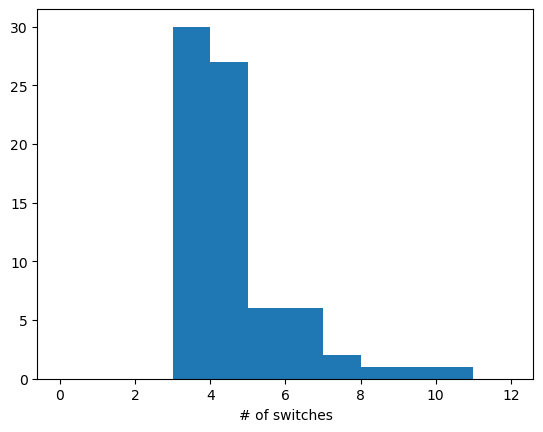

In [7]:
plt.hist(trusty_cls_df.filter(pl.col("class") == "CNCO").select("n_transitions"), bins=np.arange(13));
plt.xlabel("# of switches")

In [12]:
len(trusty_cls_df["class"])

3055

In [8]:
trusty_cls_df["class"].value_counts().sort(by="count")

class,count
str,u32
"""CNCO""",74
"""GC""",491
"""ambiguous""",1211
"""CO""",1279


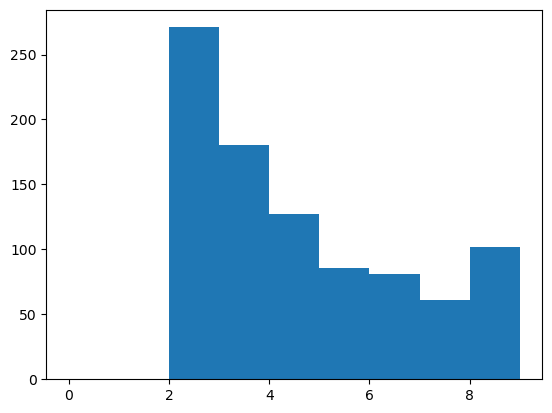

In [9]:
plt.hist(trusty_cls_df.filter(pl.col("class") == "ambiguous").select(pl.col("snp_positions_on_read").list.len()), bins=np.arange(10));

In [10]:
(trusty_cls_df.filter(pl.col("class") == "GC")).select((pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)).alias("diff"))["diff"].value_counts()

diff,count
i64,u32
1,447
3,8
2,31
4,3
5,2


In [11]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(
        (trusty_cls_df.filter(pl.col("class") == "GC")).filter((pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)) == 2)
        .select([
            "read_length",
            "idx_transitions", 
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("before_first"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1).alias("first"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)).alias("second"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1).alias("after_second"),
        ])
        .with_columns((pl.col("second") - pl.col("first")).alias("diff"))
        .sort("diff", descending=True)
    )


read_length,idx_transitions,before_first,first,second,after_second,diff
i64,list[i64],i64,i64,i64,i64,i64
15384,"[0, 2]",2587,6107,12079,13712,5972
10150,"[1, 3]",2830,3426,6920,7309,3494
14549,"[0, 2]",1663,2576,4781,6918,2205
23954,"[0, 2]",12600,17072,19217,19247,2145
8843,"[4, 6]",5334,5496,6644,7160,1148
12426,"[0, 2]",1720,1796,2855,4296,1059
13845,"[8, 10]",3897,4198,5098,5112,900
19995,"[0, 2]",10148,10476,11176,12999,700
10927,"[3, 5]",4155,4569,5113,9073,544


# Empirical GC tracts?

In [12]:
def plot_tract_lengths(df):

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].hist(df.select(pl.col("idx_transitions").list.len()), log=True);
    axs[0].set_title("# of transitions");    

    xdf = (df
#        .filter(pl.col("sample_id") == focal_sample_id)
#        .filter(pl.col("class") == "GC")
        .filter(pl.col("idx_transitions").list.len() == 2)
        .select(
            pl.col("snp_positions_on_read"),
            pl.col("idx_transitions"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("first_transition_snp"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1).alias("last_transition_snp"),
        )
        .with_columns((pl.col("last_transition_snp") - pl.col("first_transition_snp")).alias("tract_upper_bound"))
    )

    axs[1].hist(xdf["tract_upper_bound"], bins=50);
    axs[1].axvline(xdf["tract_upper_bound"].mean(), c="black")
    axs[1].set_title("Tract upper bound");

    xdf = (df
#        .filter(pl.col("sample_id") == focal_sample_id)
#        .filter(pl.col("class") == "GC")
        .filter(pl.col("idx_transitions").list.len() == 2)          
        .select(
            pl.col("snp_positions_on_read"),
            pl.col("idx_transitions"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1).alias("first_transition_snp"),
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)).alias("last_transition_snp"),
        )
        .with_columns((pl.col("last_transition_snp") - pl.col("first_transition_snp")).alias("tract_lower_bound"))
    )

    n_zeros = np.sum(xdf["tract_lower_bound"].to_numpy()==0)
    mn = xdf["tract_lower_bound"].mean()
    # cnt = xdf["tract_lower_bound"].value_counts().sort("tract_lower_bound")
    # axs[1].barh(np.arange(len(cnt)), cnt["count"], height=0.8);
    # axs[1].set_yticks(np.arange(len(cnt)), cnt["tract_lower_bound"], fontsize=6);
    
    axs[2].hist(xdf["tract_lower_bound"], bins=50, log=True);
    axs[2].axvline(xdf["tract_lower_bound"].mean(), c="black")
    axs[2].set_title(f"Tract lower bound, mean = {mn:1.3f}");
    #axs[1].set_xscale("log");


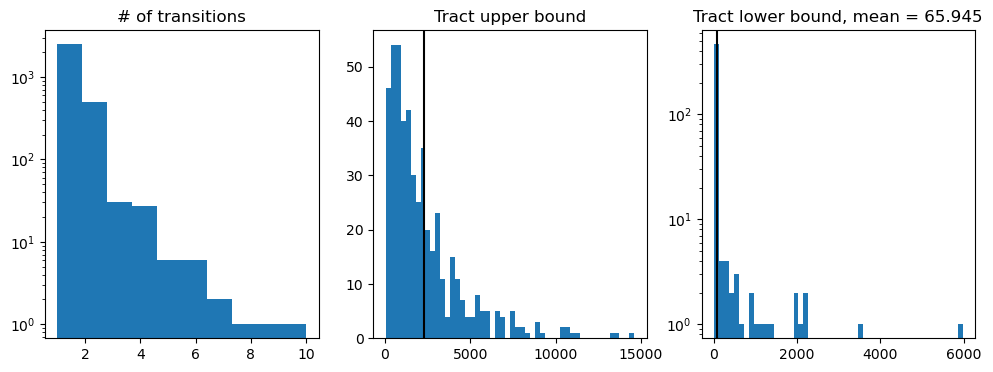

In [13]:
plot_tract_lengths(trusty_cls_df)


In [115]:
np.histogram(both_df.select(pl.col("idx_transitions").list.len()), bins=np.arange(5), density=True)[0]

array([9.99921414e-01, 6.73594083e-05, 1.12265680e-05, 0.00000000e+00])

In [104]:
both_df

read_length,snp_positions_on_read,idx_transitions,sample_id,read_name
i64,list[i64],list[i64],str,str
26697,"[1542, 2963, … 24324]",[25],"""PD50489e""","""m64174e_220620…"
18384,"[4531, 5034, … 14753]",[0],"""PD50489e""","""m64094e_220717…"
7552,"[5427, 5526]",[0],"""PD50489e""","""m64174e_220620…"
21089,"[4721, 5695, … 19487]",[2],"""PD50489e""","""m64094e_220715…"
12853,"[2118, 2865, … 11291]",[4],"""PD50489e""","""m64174e_220620…"
22981,"[1936, 7101, … 17093]",[2],"""PD50489e""","""m64094e_220715…"
19951,"[1871, 1946, … 16753]",[1],"""PD50489e""","""m64094e_220717…"
16265,"[11515, 11590, … 12650]",[1],"""PD50489e""","""m64094e_220717…"
17076,"[2138, 3377, … 15562]",[29],"""PD50489e""","""m64174e_220620…"


### Cutting off the edge more aggressively

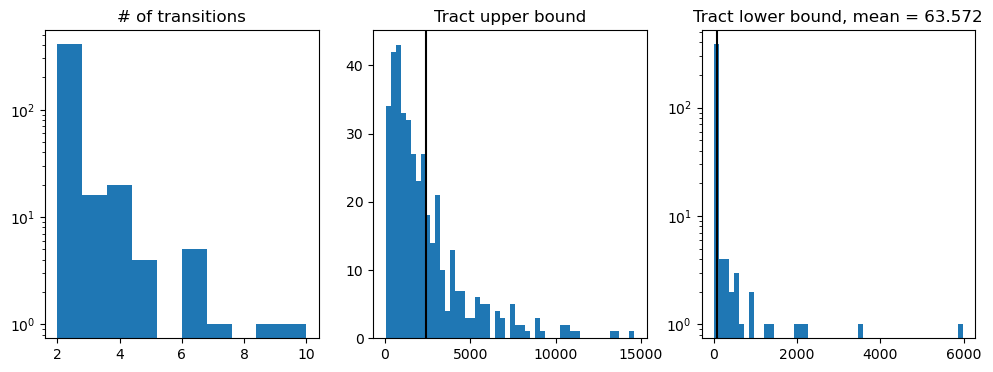

In [14]:
plot_tract_lengths(trusty_cls_df
    .with_columns(
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1).alias("first_transition_snp"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)).alias("last_transition_snp"),
    )
    .filter((pl.col("first_transition_snp") > 3000) & ((pl.col("read_length") - pl.col("last_transition_snp")) > 3000))
)


In [15]:
outer_diffs = (trusty_cls_df
    .filter(pl.col("class") == "GC")
    .with_columns(
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("first_transition_snp"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1).alias("last_transition_snp"),
    )
    .select((pl.col("last_transition_snp") - pl.col("first_transition_snp")).alias("outer_diff"))
)

In [16]:
np.quantile(outer_diffs, 0.95)

6797.0

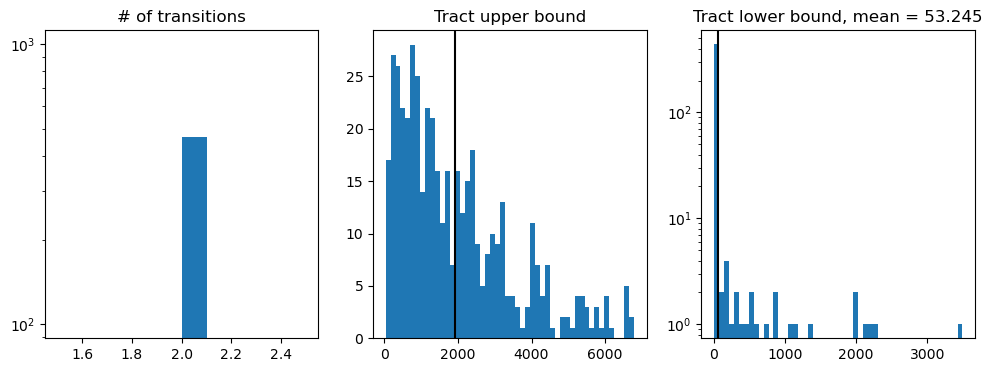

In [17]:
plot_tract_lengths(trusty_cls_df
    .filter(pl.col("class") == "GC")
    .with_columns(
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("first_transition_snp"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1).alias("last_transition_snp"),
    )
    .filter((pl.col("last_transition_snp") - pl.col("first_transition_snp")) < 6800)
)


In [56]:
aug_both_df = (both_df
    .with_columns(
        prob_inside = 1 - (pl.col("snp_positions_on_read").list.get(0) + pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) / pl.col("read_length"),
        n_transitions = pl.col("idx_transitions").list.len(),
    )
    .with_columns(
        rounded_prob_inside = pl.col("prob_inside") // 0.1 * 0.1,
    )
)

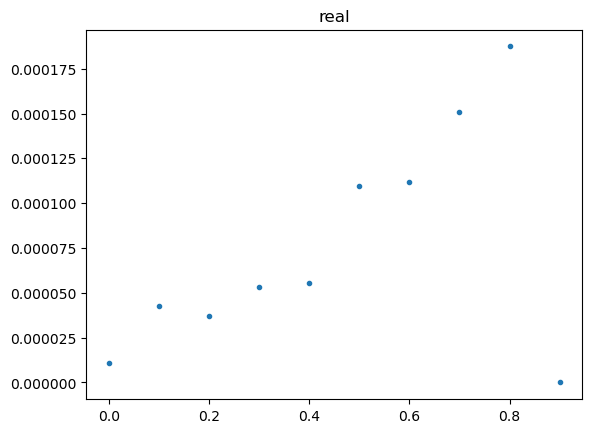

In [65]:
ps = np.arange(0, 1, 0.1)

def histme(df):
    hs = []
    for p in ps:
        hs.append(
            np.histogram(
                df.filter(pl.col("rounded_prob_inside") == p)["n_transitions"],
                bins=np.arange(0, 4),
                density=True,
            )[0]
        )
    return hs

plt.plot(ps, [x[1] for x in histme(aug_both_df)], '.')
plt.title("real");

In [18]:
where_trans_df = (trusty_cls_df
    .filter(pl.col("class") == "GC")
    .with_columns(n_possible_transitions = pl.col("snp_positions_on_read").list.len() - 1)
    .explode("idx_transitions")
    .group_by(["n_possible_transitions", "idx_transitions"])
    .len()
    .sort(by=["n_possible_transitions", "idx_transitions"])
)

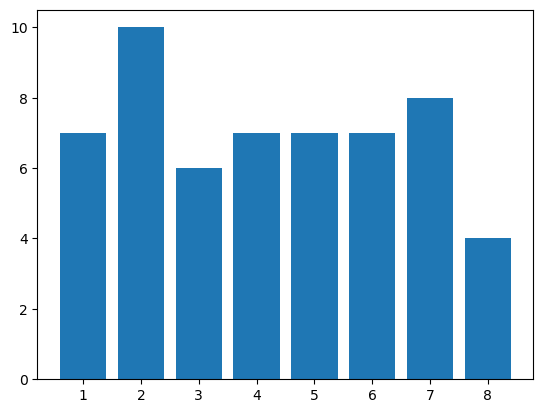

In [19]:
df = where_trans_df.filter(pl.col("n_possible_transitions") == 9)
plt.bar(df["idx_transitions"], df["len"]);

In [ ]:
import scipy.stats

def F(df):
    n_pos = df.select("n_possible_transitions").row(0)[0]
    edges = df.filter((pl.col("idx_transitions") == 0) | (pl.col("idx_transitions") == n_pos-1))["len"].sum()
    total = df["len"].sum()
    return pl.DataFrame({
        "n_possible_transitions": n_pos,
        "n_at_edges": edges,
        "n_total": total,    
        "edge_p_value": scipy.stats.binomtest(k=edges, n=total, p=2/n_pos).pvalue,
        "uniform_p_value": scipy.stats.chisquare(df["idx_transitions"]).pvalue,
    })

pdf = where_trans_df.group_by("n_possible_transitions").map_groups(F)

In [ ]:
pdf

In [ ]:
scipy.stats.chi2.sf(-2*np.log(pdf["uniform_p_value"][:20]).sum(), 2*20)

In [ ]:
scipy.stats.chi2.sf(-2*np.log(pdf["edge_p_value"][:15]).sum(), 2*15)

In [ ]:
real_edge_df = (trusty_cls_df
    .filter(pl.col("class") == "GC")
    .with_columns(n_possible_transitions = pl.col("snp_positions_on_read").list.len() - 1)
    .with_columns(
        (pl.col("idx_transitions").list.get(0) == 0).alias("is_left_edge"),
        (pl.col("idx_transitions").list.get(-1) == (pl.col("n_possible_transitions") - 1)).alias("is_right_edge")
    )
    .with_columns((pl.col("is_left_edge") | pl.col("is_right_edge")).alias("is_edge"))
    .group_by("n_possible_transitions", "is_edge")
    .len()
    .sort(by=["n_possible_transitions", "is_edge"]) 
    .group_by("n_possible_transitions")
    .map_groups(
        lambda group: group.with_columns(
            (group['len'] / group['len'].sum()).alias('fraction'), 
            pl.lit(group["len"].sum()).alias("total")
        )    
    )
    .filter(pl.col("is_edge"))
)

In [ ]:
real_edge_df

In [20]:
single_where_df = (trusty_cls_df
    .filter(pl.col("n_transitions") == 1)
    .with_columns(n_possible_transitions = pl.col("snp_positions_on_read").list.len() - 1)
    .explode("idx_transitions")
    .group_by(["n_possible_transitions", "idx_transitions"])
    .len()
    .sort(by=["n_possible_transitions", "idx_transitions"])
)

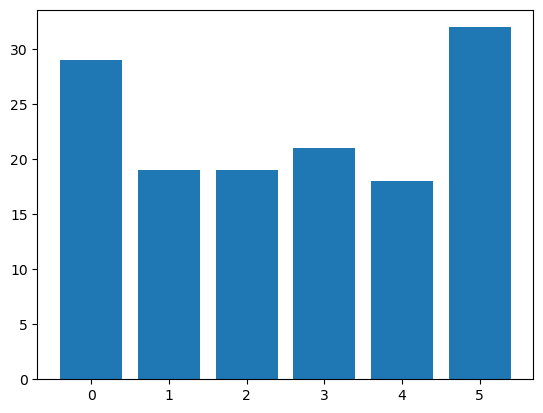

In [21]:
df = single_where_df.filter(pl.col("n_possible_transitions") == 6)
plt.bar(df["idx_transitions"], df["len"]);

In [39]:
import scipy.stats

def F(df):
    n_pos = df.select("n_possible_transitions").row(0)[0]
    edges = df.filter((pl.col("idx_transitions") == 0) | (pl.col("idx_transitions") == n_pos-1))["len"].sum()
    total = df["len"].sum()
    return pl.DataFrame({
        "n_possible_transitions": n_pos,
        "n_at_edges": edges,
        "n_total": total,    
        "edge_p_value": scipy.stats.binomtest(k=edges, n=total, p=2/n_pos).pvalue,
        "uniform_p_value": scipy.stats.chisquare(df["idx_transitions"]).pvalue,
    })

pdf = single_where_df.filter(pl.col("n_possible_transitions") >= 2).group_by("n_possible_transitions").map_groups(F)

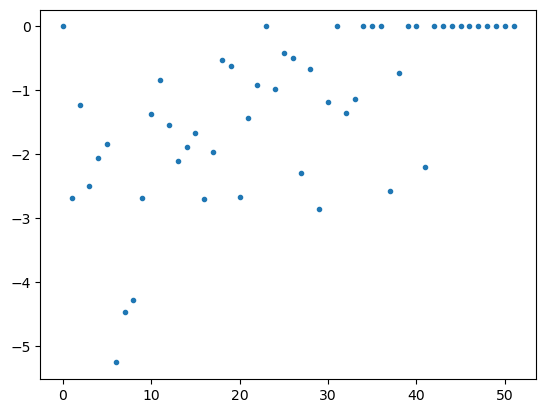

In [46]:
plt.plot(np.log10(pdf["edge_p_value"]), '.');

In [30]:
where_pos_df = (
    trusty_cls_df
    .filter(pl.col("idx_transitions").list.len() == 1)
    .with_columns(
        pl.min_horizontal(
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
            (pl.col("read_length") - pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1)),
        ).alias("gap")
    )
)

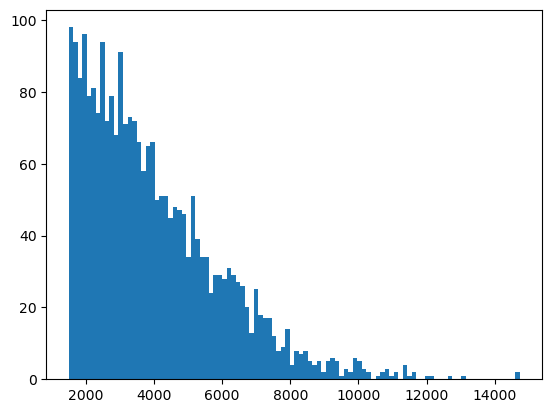

In [32]:
plt.hist(where_pos_df["gap"], bins=100);

# Get some non-event reads

In [13]:
%%time
focal_sample_id = "PD50489e"
# t2t_chrom = "chr2"
# denovo_chrom = t2t_chrom + "_RagTag"
certainty = "0.95"

total_reads = []
all_sampled_reads = []

#for focal_sample_id in tqdm(sample_ids):
for focal_sample_id in [focal_sample_id]:
    for t2t_chrom in (aut_chrom_names):
        denovo_chrom = t2t_chrom + "_RagTag"
        
        patterns_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_{certainty}.candidate_reads.patterns.parquet"

        pat_df = pl.scan_parquet(patterns_filename)
        all_sampled_reads.append(pat_df)
        
all_sampled_reads = pl.concat(all_sampled_reads).collect(streaming=True)


CPU times: user 2.57 s, sys: 597 ms, total: 3.17 s
Wall time: 3.73 s


In [20]:
%%time
read_length_list, snp_positions_on_read_list = all_sampled_reads.select("read_length", "snp_positions_on_read").to_numpy().T

idx_transitions_list = inference.simulate_many_read_patterns(
    read_length_list,
    snp_positions_on_read_list,
    1,
    100,
    1,
    42,
)

sim_df = pl.from_pandas(pd.DataFrame({
    "idx_transitions": list(idx_transitions_list), 
    "snp_positions_on_read": list(snp_positions_on_read_list),
    "read_length": list(read_length_list),
}))



CPU times: user 26 s, sys: 1.72 s, total: 27.8 s
Wall time: 28.4 s


In [34]:
%%time
where_pos_df = (
    sim_df
    .filter(pl.col("idx_transitions").list.len() == 1)
    .with_columns(
        pl.min_horizontal(
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
            (pl.col("read_length") - pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1)),
        ).alias("gap")
    )
)

CPU times: user 166 ms, sys: 142 ms, total: 307 ms
Wall time: 216 ms


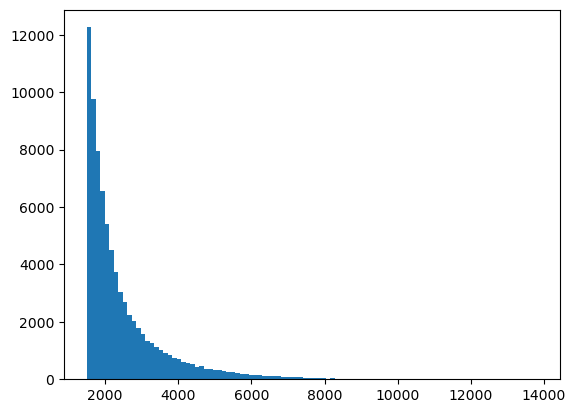

In [40]:
plt.hist(where_pos_df.filter(pl.col("snp_positions_on_read").list.len() == 2)["gap"], bins=100);

In [66]:
%%time
where_trans_df = (
    pl.DataFrame({"idx_transitions": list(idx_transitions_list), "snp_positions_on_read": list(snp_positions_on_read_list)})
    .filter(pl.col("idx_transitions").list.len() == 1)
    .with_columns(n_possible_transitions = pl.col("snp_positions_on_read").list.len() - 1)
    .explode("idx_transitions")
    .group_by(["n_possible_transitions", "idx_transitions"])
    .len()
    .sort(by=["n_possible_transitions", "idx_transitions"])
)

CPU times: user 23.5 s, sys: 52.5 s, total: 1min 15s
Wall time: 1min 15s


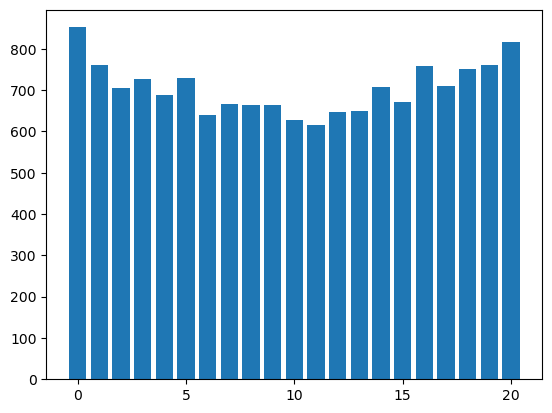

In [67]:
df = where_trans_df.filter(pl.col("n_possible_transitions") == 21)
plt.bar(df["idx_transitions"], df["len"]);

In [75]:
import scipy.stats

def F(df):
    n_pos = df.select("n_possible_transitions").row(0)[0]
    edges = df.filter((pl.col("idx_transitions") == 0) | (pl.col("idx_transitions") == n_pos-1))["len"].sum()
    total = df["len"].sum()
    return pl.DataFrame({
        "n_possible_transitions": n_pos,
        "n_at_edges": edges,
        "n_total": total,    
        "edge_p_value": scipy.stats.binomtest(k=edges, n=total, p=2/n_pos).pvalue,
        "uniform_p_value": scipy.stats.chisquare(df["idx_transitions"]).pvalue,
    })

pdf = (where_trans_df
    .filter(pl.col("idx_transitions").is_not_null())
    .filter(pl.col("n_possible_transitions")>=2)
    .group_by("n_possible_transitions")
    .map_groups(F)
)

/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8064: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [77]:
pdf

n_possible_transitions,n_at_edges,n_total,edge_p_value,uniform_p_value
i64,i64,i64,f64,f64
2,13847,13847,1.0,0.317311
3,10598,15881,0.859711,0.367879
4,7991,15813,0.181552,0.34303
5,6193,15315,0.269118,0.287297
6,4916,14672,0.661513,0.22064
7,4016,13936,0.523772,0.155681
8,3323,13170,0.539371,0.100559
9,2714,12211,0.991316,0.059145
10,2301,11579,0.736223,0.031497


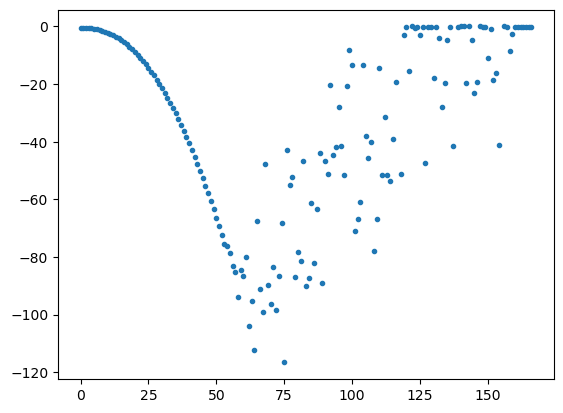

In [78]:
plt.plot(np.log10(pdf["uniform_p_value"]), '.')

In [82]:
scipy.stats.chi2.sf(-2*np.log(pdf["uniform_p_value"][:20]).sum(), 2*20)

1.1305341408166874e-33

In [84]:
scipy.stats.chi2.sf(-2*np.log(pdf["edge_p_value"][:40]).sum(), 2*40)

0.6069689919814163

In [126]:
# xdf = (
#     pl.DataFrame({"idx_transitions": list(idx_transitions_list), "snp_positions_on_read": list(snp_positions_on_read_list)})
#     .filter(pl.col("idx_transitions").is_not_null())
#     .with_columns(n_possible_transitions = pl.col("snp_positions_on_read").list.len() - 1)
#     .filter(pl.col("n_possible_transitions")>=2)
#     .with_columns(
#         (pl.col("idx_transitions").list.get(0) == 0).alias("is_left_edge"),
#         (pl.col("idx_transitions").list.get(-1) == (pl.col("n_possible_transitions") - 1)).alias("is_right_edge")
#     )
#     .with_columns((pl.col("is_left_edge") | pl.col("is_right_edge")).alias("is_edge"))
# )

In [142]:
%%time
sim_edge_df = (
    pl.DataFrame({"idx_transitions": list(idx_transitions_list), "snp_positions_on_read": list(snp_positions_on_read_list)})
    .filter(pl.col("idx_transitions").is_not_null())
    .filter(pl.col("idx_transitions").list.len() == 2)
    .with_columns(n_possible_transitions = pl.col("snp_positions_on_read").list.len() - 1)
    .filter(pl.col("n_possible_transitions")>=2)
    .with_columns(
        (pl.col("idx_transitions").list.get(0) == 0).alias("is_left_edge"),
        (pl.col("idx_transitions").list.get(-1) == (pl.col("n_possible_transitions") - 1)).alias("is_right_edge")
    )
    .with_columns((pl.col("is_left_edge") | pl.col("is_right_edge")).alias("is_edge"))
    .group_by("n_possible_transitions", "is_edge")
    .len()
    .sort(by=["n_possible_transitions", "is_edge"]) 
    .group_by("n_possible_transitions")
    .map_groups(
        lambda group: group.with_columns(
            (group['len'] / group['len'].sum()).alias('fraction'), 
            pl.lit(group["len"].sum()).alias("total")
        )    
    )
    .filter(pl.col("is_edge"))
)

CPU times: user 17.3 s, sys: 30.2 s, total: 47.5 s
Wall time: 47.5 s


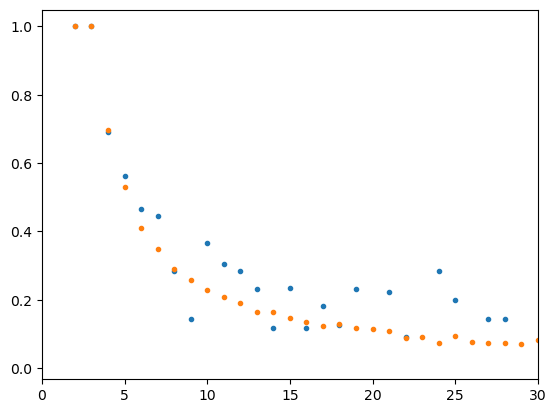

In [143]:
plt.plot(
    real_edge_df["n_possible_transitions"], real_edge_df["fraction"], '.',
)

plt.plot(
    sim_edge_df["n_possible_transitions"], sim_edge_df["fraction"], '.',
)

plt.xlim(0,30);


In [150]:
rows = (sim_edge_df
    .join(real_edge_df, on=["n_possible_transitions", "is_edge"])
    .select(["len", "total", "len_right", "total_right"])
    .rows()
)

In [152]:
[scipy.stats.fisher_exact([[row[0], row[1]-row[0]], row[2], row[3]-row[2]]) 

NameError: name 'row' is not defined

In [29]:
%%time
sim_df = pl.DataFrame(
    {
        "read_length": read_length_list.astype(np.int64),
        "snp_positions_on_read": list(snp_positions_on_read_list),
        "idx_transitions": list(idx_transitions_list),
        "sample_id": all_sampled_reads["sample_id"],
        "class": all_sampled_reads["class"],
    },
)

CPU times: user 8.56 s, sys: 1.44 s, total: 10 s
Wall time: 10 s


In [43]:
sim_df.shape

(3206427, 5)

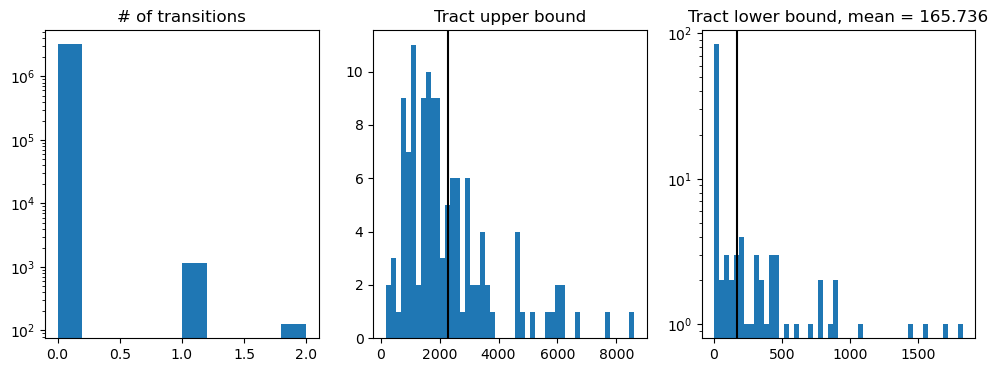

In [32]:
plot_tract_lengths(sim_df.filter(pl.col("sample_id") == focal_sample_id))

In [14]:
read_length_list, snp_positions_on_read_list = all_sampled_reads.select("read_length", "snp_positions_on_read").to_numpy().T

def runme(CO_prob, mean_tract_length, recomb_rate):
    idx_transitions_list = inference.simulate_many_read_patterns(
        read_length_list,
        snp_positions_on_read_list,
        CO_prob,
        mean_tract_length,
        recomb_rate,
        42,
    )
    
    sim_df = pl.from_pandas(pd.DataFrame({
        "idx_transitions": list(idx_transitions_list), 
        "snp_positions_on_read": list(snp_positions_on_read_list),
        "read_length": list(read_length_list),
    }))

    aug_sim_df = (sim_df
        .with_columns(
            prob_inside = 1 - (pl.col("snp_positions_on_read").list.get(0) + pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) / pl.col("read_length"),
            n_transitions = pl.col("idx_transitions").list.len(),
        )
        .with_columns(
            rounded_prob_inside = pl.col("prob_inside") // 0.1 * 0.1,
        )
    )

    return aug_sim_df

In [15]:
tract_lengths = np.arange(50, 800, 50)

sim_params = (
    [(0, -1, 0)] +                           # No recombination at all
    [(1, -1, 1)] +                           # CO at every read
    [(0, t, 1) for t in tract_lengths]      # GC at every read
)



res = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(CO_prob, mean_tract_length, recomb_rate) 
        for CO_prob, mean_tract_length, recomb_rate in sim_params
)

res_dict = dict(zip(sim_params, res))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:  3.3min remaining: 10.6min
IOStream.flush timed out
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:  4.1min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:  4.4min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:  4.7min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:  4.7min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:  4.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  5.1min finished


In [22]:
def histme(df):
    hs = []
    for p in np.arange(0, 1, 0.1):
        hs.append(
            np.histogram(
                df.filter(pl.col("rounded_prob_inside") == p)["n_transitions"],
                bins=np.arange(0, 4),
                density=True,
            )[0]
        )
    return hs

In [182]:
no_recomb_hist = np.histogram(res_dict[(0, -1, 0)]["n_transitions"], bins=np.arange(4), density=True)[0]
co_hist = np.histogram(res_dict[(1, -1, 1)]["n_transitions"], bins=np.arange(4), density=True)[0]
tracts_hists = {t:np.histogram(res_dict[(0, t, 1)]["n_transitions"], bins=np.arange(4), density=True)[0] for t in tract_lengths}

In [181]:
co_hist

array([0.64225382, 0.35774618, 0.        ])

In [183]:
tracts_hists

{50: array([0.97365541, 0.00792471, 0.01841988]),
 100: array([0.95111319, 0.01566635, 0.03322047]),
 150: array([0.93099609, 0.0233269 , 0.04567701]),
 200: array([0.9130094 , 0.03077382, 0.05621678]),
 250: array([0.8967271 , 0.03804765, 0.06522525]),
 300: array([0.88175967, 0.04506761, 0.07317272]),
 350: array([0.86799356, 0.05192197, 0.08008447]),
 400: array([0.85519708, 0.05861415, 0.08618877]),
 450: array([0.84338985, 0.06506651, 0.09154364]),
 500: array([0.8324749 , 0.07131365, 0.09621145]),
 550: array([0.82230501, 0.07724954, 0.10044545]),
 600: array([0.81279692, 0.08303448, 0.1041686 ]),
 650: array([0.80382869, 0.08863823, 0.10753309]),
 700: array([0.79531859, 0.09409258, 0.11058883]),
 750: array([0.7873577 , 0.0993358 , 0.11330649])}

In [185]:
(1-1e-7*1e4)*no_recomb_hist + (1e-7*1e4*0.12)*co_hist +  (1e-7*1e4*(1-0.12))*tracts_hists[50]

array([9.99933887e-01, 4.99032849e-05, 1.62094942e-05])

In [187]:
(1e-7*1e4*0.12)*co_hist

array([7.70704588e-05, 4.29295412e-05, 0.00000000e+00])

array([8.56816762e-04, 6.97374367e-06, 1.62094942e-05])

In [173]:
isit = runme(0.12, 45, 1e-7)

In [174]:
np.histogram(isit["n_transitions"], bins=np.arange(4), density=True)[0]

array([9.99913618e-01, 6.82950621e-05, 1.80872767e-05])

In [175]:
histme(isit)

[array([9.99998892e-01, 1.10780616e-06, 0.00000000e+00]),
 array([9.99948970e-01, 4.25249622e-05, 8.50499243e-06]),
 array([9.99970369e-01, 2.96305076e-05, 0.00000000e+00]),
 array([9.99939821e-01, 4.34624167e-05, 1.67163141e-05]),
 array([9.99904379e-01, 8.32832092e-05, 1.23382532e-05]),
 array([9.99893492e-01, 8.63575259e-05, 2.01500894e-05]),
 array([9.99832419e-01, 1.35661028e-04, 3.19202420e-05]),
 array([9.99779930e-01, 1.65052339e-04, 5.50174463e-05]),
 array([9.99709558e-01, 2.06119887e-04, 8.43217719e-05]),
 array([1., 0., 0.])]

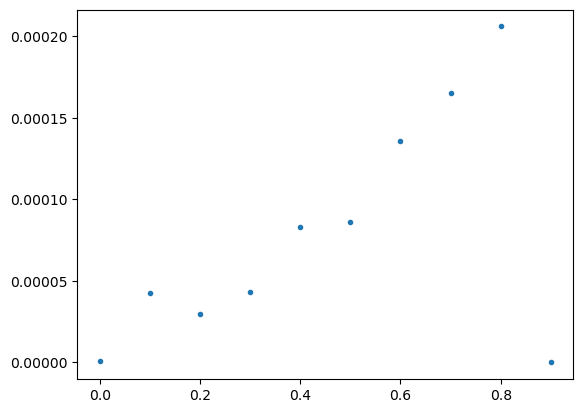

In [176]:
plt.plot(np.arange(0, 1, 0.1), [x[1] for x in histme(isit)], '.')


In [29]:
{k:v[2]/(v[1]+v[2]) for k,v in res_dict.items()}

/tmp/ipykernel_2276/2669343502.py:1: RuntimeWarning: invalid value encountered in scalar divide
  {k:v[2]/(v[1]+v[2]) for k,v in res_dict.items()}


{(0, -1, 0): nan,
 (1, -1, 1): 0.0,
 (0, 50, 1): 0.6991902642295672,
 (0, 100, 1): 0.6795383790956415,
 (0, 150, 1): 0.6619481505586289,
 (0, 200, 1): 0.6462397240874918,
 (0, 250, 1): 0.6315814904405125,
 (0, 300, 1): 0.6188474107757518,
 (0, 350, 1): 0.6066709350318592,
 (0, 400, 1): 0.5952143010984278,
 (0, 450, 1): 0.5845319908634516,
 (0, 500, 1): 0.5743106763944247,
 (0, 550, 1): 0.5652688998641547,
 (0, 600, 1): 0.5564470315017168,
 (0, 650, 1): 0.548159088343728,
 (0, 700, 1): 0.5402973658227386,
 (0, 750, 1): 0.5328502160387902}

In [48]:
np.max(np.random.geometric(1/50, 100))

257

In [42]:
snp_gaps = np.concatenate([np.diff(x) for x in snp_positions_on_read_list])

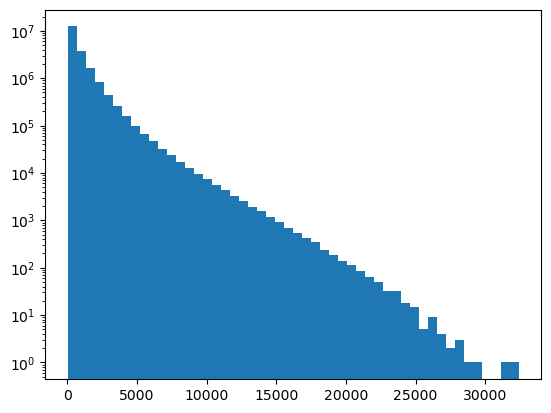

In [45]:
plt.hist(snp_gaps, bins=50, log=True);

In [46]:
snp_gaps.mean()

818.587835755243

In [51]:
snp_lens = np.array([len(x) for x in snp_positions_on_read_list])

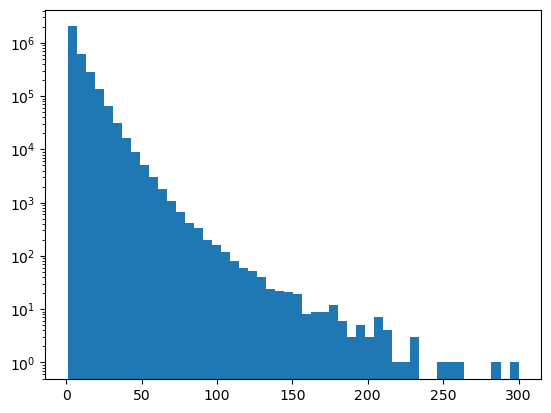

In [55]:
plt.hist(snp_lens, bins=50, log=True);

In [56]:
np.mean(snp_lens)

7.164133473177465

In [57]:
np.mean(2/snp_lens)

0.7701808399801328

## Try all of them

In [136]:
both_df = (
    pl.concat([
        (trusty_cls_df
            .filter(pl.col("class") != "CNCO")
            .filter(pl.col("sample_id") == focal_sample_id)
            .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
        ), 
        (all_sampled_reads
            .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
        )
    ])
)

In [137]:
gc_inputs = both_df.select(["read_length", "snp_positions_on_read", "idx_transitions"]).with_columns(weight=1).to_numpy().T

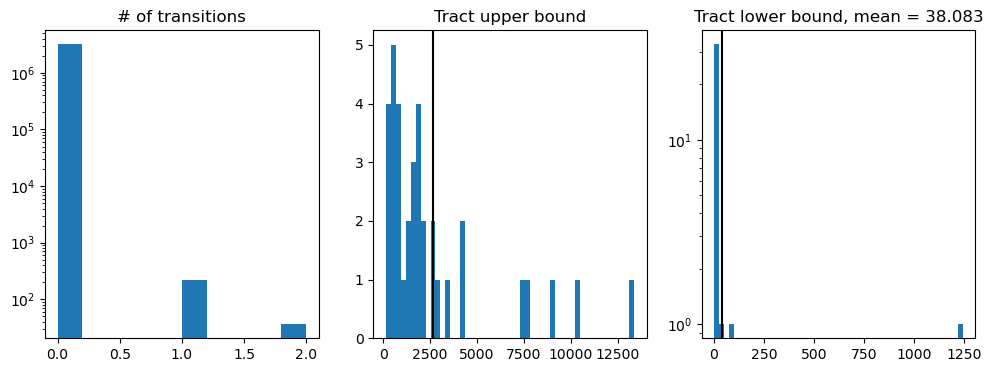

In [138]:
plot_tract_lengths(both_df)


In [139]:
np.histogram(
    both_df.select(pl.col("idx_transitions").list.len().alias("n_transitions"))["n_transitions"], 
    bins=np.arange(4), 
    density=True,
)[0]

array([9.99921414e-01, 6.73594083e-05, 1.12265680e-05])

In [140]:
both_df.select(pl.col("idx_transitions").list.len().alias("n_transitions"))["n_transitions"].value_counts()

n_transitions,count
u32,u32
0,3206427
2,36
1,216


In [144]:
%%time
read_length_list, snp_positions_on_read_list, idx_transitions_list, weights_list = gc_inputs

inference.maximum_likelihood_all_reads(
    read_length_list,
    snp_positions_on_read_list,
    idx_transitions_list,
    weights_list,
    [0, 1],
    [1, 10000],
    [1e-7, 1e-7],
)

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:351: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(


Current:	[1.05e-02 1.05e+01 1.00e-07]
Current:	[1.1e-02 1.1e+01 1.0e-07]
Current:	[1.1e-02 1.1e+01 1.0e-07]
Current:	[1.20000000e-02 1.18333333e+01 1.00000000e-07]
Current:	[1.25000000e-02 1.31666667e+01 1.00000000e-07]
Current:	[1.45000000e-02 1.33333333e+01 1.00000000e-07]
Current:	[1.70000000e-02 1.63333333e+01 1.00000000e-07]
Current:	[2.00000000e-02 1.91666667e+01 1.00000000e-07]
Current:	[2.65e-02 2.25e+01 1.00e-07]
Current:	[3.45000000e-02 3.13333333e+01 1.00000000e-07]
Current:	[4.70000000e-02 4.03333333e+01 1.00000000e-07]
Current:	[6.80000000e-02 5.58333333e+01 1.00000000e-07]
Current:	[7.31666667e-02 6.25000000e+01 1.00000000e-07]
Current:	[9.09444444e-02 7.44444444e+01 1.00000000e-07]
Current:	[9.09444444e-02 7.44444444e+01 1.00000000e-07]
Current:	[7.67777778e-02 6.34444444e+01 1.00000000e-07]
Current:	[7.67777778e-02 6.34444444e+01 1.00000000e-07]
Current:	[8.75586420e-02 7.22484568e+01 1.00000000e-07]
Current:	[8.6188786e-02 7.0993570e+01 1.0000000e-07]
Current:	[8.70538

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3125.787864774684
             x: [ 1.189e-01  4.409e+01  1.000e-07]
           nit: 91
          nfev: 173
 final_simplex: (array([[ 1.189e-01,  4.409e+01,  1.000e-07],
                       [ 1.189e-01,  4.409e+01,  1.000e-07],
                       [ 1.189e-01,  4.409e+01,  1.000e-07],
                       [ 1.189e-01,  4.409e+01,  1.000e-07]]), array([ 3.126e+03,  3.126e+03,  3.126e+03,  3.126e+03]))

## Try using only reads with many SNPS

In [145]:
#gc_inputs = trusty_cls_df.filter(pl.col("class") == "GC").select(["read_length", "snp_positions_on_read", "idx_transitions"]).to_numpy()

candidates_inputs = (trusty_cls_df
    .filter(pl.col("class") != "CNCO")
    .filter(pl.col("sample_id") == focal_sample_id)
    .filter(pl.col("snp_positions_on_read").list.len() >= 5)
    .select(["read_length", "snp_positions_on_read", "idx_transitions"])
    .with_columns(weight=1)
    .to_numpy()
)

non_candidates_input = (all_sampled_reads
    .filter(pl.col("snp_positions_on_read").list.len() >= 5)
    .select(["read_length", "snp_positions_on_read", "idx_transitions"])
    .with_columns(weight=1)
    .to_numpy()
)

gc_inputs = np.concatenate([candidates_inputs, non_candidates_input])


In [148]:
%%time
read_length_list, snp_positions_on_read_list, idx_transitions_list, weights_list = gc_inputs.T

inference.maximum_likelihood_all_reads(
    read_length_list,
    snp_positions_on_read_list,
    idx_transitions_list,
    weights_list,
    [0, 1],
    [1, 10000],
    [1e-7, 1e-7],
)

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:351: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(


Current:	[1.05e-02 1.05e+01 1.00e-07]
Current:	[1.1e-02 1.1e+01 1.0e-07]
Current:	[1.1e-02 1.1e+01 1.0e-07]
Current:	[1.20000000e-02 1.18333333e+01 1.00000000e-07]
Current:	[1.25000000e-02 1.31666667e+01 1.00000000e-07]
Current:	[1.45000000e-02 1.33333333e+01 1.00000000e-07]
Current:	[1.70000000e-02 1.63333333e+01 1.00000000e-07]
Current:	[2.00000000e-02 1.91666667e+01 1.00000000e-07]
Current:	[2.65e-02 2.25e+01 1.00e-07]
Current:	[3.45000000e-02 3.13333333e+01 1.00000000e-07]
Current:	[4.70000000e-02 4.03333333e+01 1.00000000e-07]
Current:	[6.80000000e-02 5.58333333e+01 1.00000000e-07]
Current:	[7.31666667e-02 6.25000000e+01 1.00000000e-07]
Current:	[9.09444444e-02 7.44444444e+01 1.00000000e-07]
Current:	[9.09444444e-02 7.44444444e+01 1.00000000e-07]
Current:	[7.67777778e-02 6.34444444e+01 1.00000000e-07]
Current:	[7.67777778e-02 6.34444444e+01 1.00000000e-07]
Current:	[8.75586420e-02 7.22484568e+01 1.00000000e-07]
Current:	[8.6188786e-02 7.0993570e+01 1.0000000e-07]
Current:	[8.70538

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2500.7718882817894
             x: [ 1.156e-01  4.517e+01  1.000e-07]
           nit: 97
          nfev: 186
 final_simplex: (array([[ 1.156e-01,  4.517e+01,  1.000e-07],
                       [ 1.156e-01,  4.517e+01,  1.000e-07],
                       [ 1.156e-01,  4.517e+01,  1.000e-07],
                       [ 1.156e-01,  4.517e+01,  1.000e-07]]), array([ 2.501e+03,  2.501e+03,  2.501e+03,  2.501e+03]))

In [162]:
np.histogram(
    (trusty_cls_df
        .filter(pl.col("class") != "CNCO")
        .filter(pl.col("sample_id") == focal_sample_id)
        .filter(pl.col("snp_positions_on_read").list.len() >= 20)
        .select(pl.col("idx_transitions").list.len())
    ),
    bins=np.arange(4),
    density=True,
)[0]

array([0.        , 0.88636364, 0.11363636])

## Try with cutting the 5% longest GC-s


In [163]:
#gc_inputs = trusty_cls_df.filter(pl.col("class") == "GC").select(["read_length", "snp_positions_on_read", "idx_transitions"]).to_numpy()

candidates_inputs = (trusty_cls_df
    .filter(pl.col("class") != "CNCO")
    .filter(pl.col("sample_id") == focal_sample_id)
    .filter(
        pl.when(pl.col("class") != "GC").then(pl.lit(True)).otherwise(
            (pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) - \
             pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))) < 6700
        )
    )         
    .select(["read_length", "snp_positions_on_read", "idx_transitions"])
    .with_columns(weight=1)
    .to_numpy()
)

non_candidates_input = (all_sampled_reads
    .select(["read_length", "snp_positions_on_read", "idx_transitions"])
    .with_columns(weight=1)
    .to_numpy()
)

gc_inputs = np.concatenate([candidates_inputs, non_candidates_input])


In [164]:
%%time
read_length_list, snp_positions_on_read_list, idx_transitions_list, weights_list = gc_inputs.T

inference.maximum_likelihood_all_reads(
    read_length_list,
    snp_positions_on_read_list,
    idx_transitions_list,
    weights_list,
    [0, 1],
    [1, 10000],
    [1e-7, 1e-7],
)

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:351: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(


Current:	[1.05e-02 1.00e+01 1.00e-07]
Current:	[1.08333333e-02 1.08333333e+01 1.00000000e-07]
Current:	[1.16666667e-02 1.01666667e+01 1.00000000e-07]
Current:	[1.23333333e-02 1.03333333e+01 1.00000000e-07]
Current:	[1.38333333e-02 1.13333333e+01 1.00000000e-07]
Current:	[1.61666667e-02 1.01666667e+01 1.00000000e-07]
Current:	[1.90e-02 1.15e+01 1.00e-07]
Current:	[2.43333333e-02 1.23333333e+01 1.00000000e-07]
Current:	[3.18333333e-02 1.13333333e+01 1.00000000e-07]
Current:	[4.28333333e-02 1.48333333e+01 1.00000000e-07]
Current:	[6.10e-02 1.55e+01 1.00e-07]
Current:	[8.7e-02 1.7e+01 1.0e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1.27166667e-01 2.46666667e+01 1.00000000e-07]
Current:	[1

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3025.8317143750583
             x: [ 1.225e-01  2.454e+01  1.000e-07]
           nit: 68
          nfev: 142
 final_simplex: (array([[ 1.225e-01,  2.454e+01,  1.000e-07],
                       [ 1.225e-01,  2.454e+01,  1.000e-07],
                       [ 1.225e-01,  2.454e+01,  1.000e-07],
                       [ 1.225e-01,  2.454e+01,  1.000e-07]]), array([ 3.026e+03,  3.026e+03,  3.026e+03,  3.026e+03]))

# Simulate and test

In [21]:
gc_inputs.T[1]

array([array([ 2385,  2623,  4256, 16361, 16461]), array([ 4247, 12916]),
       array([ 4864,  6928,  7597, 11405, 11866, 12372]), ...,
       array([2155]), array([1876, 2023, 2052, 2116, 2297]),
       array([1831, 3106, 3215, 3769, 3997, 4111, 4976, 5091, 6208])],
      dtype=object)

In [22]:
%%time
# test_n_reads = 100000

# test_read_length = 10000
# test_snp_positions = np.arange(0, test_read_length, 2000)[1:].astype(int)
# read_length_list = np.ones(test_n_reads) * test_read_length
# snp_positions_on_read_list = [test_snp_positions]*test_n_reads
# weights_list = np.ones(test_n_reads)

read_length_list, snp_positions_on_read_list, _, _ = gc_inputs.T
read_length_list = read_length_list * 10
snp_positions_on_read_list = snp_positions_on_read_list * 10
test_n_reads = len(read_length_list)
weights_list = np.ones(test_n_reads)

test_prob_CO = 0.1
test_tract_length = 200
test_prob_recomb = 1e-7

#test_trans = [inference.simulate_read_pattern(test_read_length, test_snp_positions, test_prob_CO, test_tract_length, test_prob_recomb) for i in range(test_n_reads)]
test_trans = [inference.simulate_read_pattern(read_length_list[i], snp_positions_on_read_list[i], test_prob_CO, test_tract_length, test_prob_recomb) for i in range(test_n_reads)]

idx_transitions_list = test_trans

print("Candidate reads:", np.sum([len(x)>0 for x in test_trans]))

Candidate reads: 239
CPU times: user 7.82 s, sys: 239 ms, total: 8.06 s
Wall time: 8.06 s


In [23]:
%%time

inference.maximum_likelihood_all_reads(
    read_length_list,
    snp_positions_on_read_list,
    idx_transitions_list,
    weights_list,
    [0, 1],
    [1, 10000],
    [test_prob_recomb, test_prob_recomb],
)


/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:255: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(


CPU times: user 52.6 s, sys: 0 ns, total: 52.6 s
Wall time: 52.6 s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2429.722807825813
             x: [ 9.837e-02  1.910e+02  1.000e-07]
           nit: 103
          nfev: 206
 final_simplex: (array([[ 9.837e-02,  1.910e+02,  1.000e-07],
                       [ 9.837e-02,  1.910e+02,  1.000e-07],
                       [ 9.837e-02,  1.910e+02,  1.000e-07],
                       [ 9.837e-02,  1.910e+02,  1.000e-07]]), array([ 2.430e+03,  2.430e+03,  2.430e+03,  2.430e+03]))